# Bias in Image based Automatic Gender Classification

## Overview

Recent studies have shown that the machine learning models for gender classification task from face images perform differently across groups defined by skin tone. In this tutorial, we will demonstrate the use of the aif360 toolbox to study the differential performance of a custom classifier. We use a bias mitigating algorithm available in aif360 with the aim of improving a classfication model in terms of the fairness metrics. We will work with the UTK dataset for this tutorial. This can be downloaded from here:
https://susanqq.github.io/UTKFace/

In a nutshell, we will follow these steps:
 - Process images and load them as an aif360 dataset
 - Learn a baseline classifier and obtain fairness metrics
 - Call the `Reweighing` algorithm to obtain instance weights
 - Learn a new classifier with the instance weights and obtain updated fairness metrics

### Call the import statements

In [2]:
%matplotlib inline

In [3]:
import glob
from skimage import io
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import Markdown, display

!pip install torch
!pip install torchsummary
import torch
import torch.utils.data
from torch.autograd import Variable
import torch.nn as nn
from torchsummary import summary

import pandas as pd
import sys
sys.path.append("../")

!pip install aif360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

In [4]:
np.random.seed(99)
torch.manual_seed(99)

# Step 1: Load and Process Images
The first step is to to download the `Aligned&cropped` images at the location mentioned above.

After unzipping the downloaded file, point the location of the folder in the `image_dir` variable below. 
The file name has the following format `age`-`gender`-`race`-`date&time`.jpg

    age: indicates the age of the person in the picture and can range from 0 to 116.
    gender: indicates the gender of the person and is either 0 (male) or 1 (female).
    race: indicates the race of the person and can be from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
    date&time: indicates the date and time an image was collected in the UTK dataset.

For this tutorial we will restict the images to contain `White` and `Others` races. We need to specify the unprivileged and priviledged groups to obtain various metrics from the aif360 toolbox. We set `White` as the priviledged group and `Others` as the unpriviledged group for computing the results with gender as the outcome variable that needs to be predicted. We set prediction as `female (1)` as the unfavorable label and `male (0)` as favorable label for the purpose of computing metrics, it does not have any special meaning in the context of gender prediction.

In [5]:
races_to_consider = [0,4]
unprivileged_groups = [{'race': 4.0}]
privileged_groups = [{'race': 0.0}]
favorable_label = 0.0 
unfavorable_label = 1.0

### Update the `image_dir` with the downloaded and extracted images location and specify the desired image size.
The images are loaded and resized using opencv library. The following code creates three key numpy arrays each containing the raw images, the race attributes and the gender labels.

In [14]:
image_dir = 'UTKFace\\'
img_size = 64

In [15]:
protected_race = []
outcome_gender = []
feature_image = []
feature_age = []

for i, image_path in enumerate(glob.glob(image_dir + "*.jpg")):
    try:
        age, gender, race = image_path.split('\\')[-1].split("_")[:3]
        age = int(age)
        gender = int(gender)
        race = int(race)
        
        if race in races_to_consider:
            protected_race.append(race)
            outcome_gender.append(gender)
            feature_image.append(resize(io.imread(image_path), (img_size, img_size)))
            feature_age.append(age)
    except:
        print("Missing: " + image_path)

feature_image_mat = np.array(feature_image)
outcome_gender_mat =  np.array(outcome_gender)
protected_race_mat =  np.array(protected_race)
age_mat = np.array(feature_age)

Missing: UTKFace\39_1_20170116174525125.jpg.chip.jpg
Missing: UTKFace\61_1_20170109142408075.jpg.chip.jpg
Missing: UTKFace\61_1_20170109150557335.jpg.chip.jpg


# Step 2: Learn a Baseline Classifier
Let's build a simple convolutional neural network (CNN) with $3$ convolutional layers and $2$ fully connected layers using the `pytorch` framework. 
![CNN](images/cnn_arch.png)
Each convolutional layer is followed by a maxpool layer. The final layer provides the logits for the binary gender predicition task.

In [8]:
class ThreeLayerCNN(torch.nn.Module):
    """
    Input: 128x128 face image (eye aligned).
    Output: 1-D tensor with 2 elements. Used for binary classification.
    Parameters:
        Number of conv layers: 3
        Number of fully connected layers: 2       
    """
    def __init__(self):
        super(ThreeLayerCNN,self).__init__()
        self.conv1 = torch.nn.Conv2d(3,6,5)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(6,16,5)
        self.conv3 = torch.nn.Conv2d(16,16,6)
        self.fc1 = torch.nn.Linear(16*4*4,120)
        self.fc2 = torch.nn.Linear(120,2)


    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1,16*4*4)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Split the dataset into train and test

Let us rescale the pixels to lie between $-1$ and $1$ and split the complete dataset into train and test sets. 
We use $70$-$30$ percentage for train and test, respectively.

In [16]:
feature_image_mat_normed = 2.0 *feature_image_mat.astype('float32') - 1.0

N = len(feature_image_mat_normed)
ids = np.random.permutation(N)
train_size=int(0.7 * N)
X_train = feature_image_mat_normed[ids[0:train_size]]
y_train = outcome_gender_mat[ids[0:train_size]]
X_test = feature_image_mat_normed[ids[train_size:]]
y_test = outcome_gender_mat[ids[train_size:]]

p_train = protected_race_mat[ids[0:train_size]]
p_test = protected_race_mat[ids[train_size:]]

age_train = age_mat[ids[0:train_size]]
age_test = age_mat[ids[train_size:]]

# Report some numbers for sanity checking 
print("N = "+ str(N))
print("train_size = " + str(train_size))
print("X_train shape: " + str(X_train.shape))

N=11770


Next, we will create the pytorch train and test data loaders after transposing and converting the images and labels. The batch size is set to $64$.

In [18]:
batch_size = 64

#X_train = X_train.transpose(0,3,1,2)
#X_test = X_test.transpose(0,3,1,2)

X_train = np.transpose(X_train,(0,3,1,2))
X_test = np.transpose(X_test,(0,3,1,2))

train = torch.utils.data.TensorDataset(Variable(torch.FloatTensor(X_train.astype('float32'))), Variable(torch.LongTensor(y_train.astype('float32'))))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test = torch.utils.data.TensorDataset(Variable(torch.FloatTensor(X_test.astype('float32'))), Variable(torch.LongTensor(y_test.astype('float32'))))
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

## Create a Plain Model
In the next few steps, we will create and intialize a model with the above described architecture and train it.

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ThreeLayerCNN().to(device)
summary(model, (3,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             456
         MaxPool2d-2            [-1, 6, 30, 30]               0
            Conv2d-3           [-1, 16, 26, 26]           2,416
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5             [-1, 16, 8, 8]           9,232
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
            Linear-8                    [-1, 2]             242
Total params: 43,186
Trainable params: 43,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.32
Params size (MB): 0.16
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


## Training the network
Next,  we will train the model summarized above. `num_epochs` specifies the number of epochs used for  training. The learning rate is set to $0.001$. We will use the `Adam` optimizer to minimze the standard cross-entropy loss for classification tasks.

In [20]:
num_epochs = 5
learning_rate = 0.001
print_freq = 100

# Specify the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training the model
num_batches = len(train_loader)
for epoch in range(num_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (idx+1) % print_freq == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, idx+1, num_batches, loss.item()))

Epoch [1/5], Step [100/129], Loss: 0.4915
Epoch [2/5], Step [100/129], Loss: 0.4080
Epoch [3/5], Step [100/129], Loss: 0.3811
Epoch [4/5], Step [100/129], Loss: 0.2648
Epoch [5/5], Step [100/129], Loss: 0.2587


#### Measure Fairness Metrics
Let's get the predictions of this trained model on the test and use them to compute various fariness metrics available in the aif360 toolbox. 

In [21]:
# Run model on test set in eval mode.
model.eval()
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.tolist()
y_pred = np.array(y_pred)

The wrapper function defined below can be used to convert the numpy arrays and the related meta data into a aif360 dataset. This will ease the process of computing metrics and comparing two datasets. The wrapper consumes the outcome array, the protected attribute array, information about unprivileged_groups and privileged_groups; and the favorable and unfavorable label to produce an instance of aif360's `BinaryLabelDataset`.

In [22]:
def dataset_wrapper(outcome, protected, unprivileged_groups, privileged_groups,
                          favorable_label, unfavorable_label):
    """ A wraper function to create aif360 dataset from outcome and protected in numpy array format.
    """
    df = pd.DataFrame(data=outcome,
                      columns=['outcome'])
    df['race'] = protected
    
    dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                       unfavorable_label=unfavorable_label,
                                       df=df,
                                       label_names=['outcome'],
                                       protected_attribute_names=['race'],
                                       unprivileged_protected_attributes=unprivileged_groups)
    return dataset

In [23]:
original_traning_dataset = dataset_wrapper(outcome=y_train, protected=p_train, 
                                                 unprivileged_groups=unprivileged_groups, 
                                                 privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)
original_test_dataset = dataset_wrapper(outcome=y_test, protected=p_test, 
                                              unprivileged_groups=unprivileged_groups, 
                                              privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)
plain_predictions_test_dataset = dataset_wrapper(outcome=y_pred, protected=p_test, 
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)

#### Obtaining the Classification Metrics
We use the `ClassificationMetric` class from the aif360 toolbox for computing metrics based on two BinaryLabelDatasets. The first dataset is the original one and the second is the output of the classification transformer (or similar). Later on we will use `BinaryLabelDatasetMetric` which computes based on a single `BinaryLabelDataset`.

In [24]:
classified_metric_nodebiasing_test = ClassificationMetric(original_test_dataset, 
                                                 plain_predictions_test_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)

In [25]:
display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil index = %f" % classified_metric_nodebiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_nodebiasing_test.false_negative_rate_difference())

#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.857547
Test set: Balanced classification accuracy = 0.856573
Test set: Statistical parity difference = -0.146871
Test set: Disparate impact = 0.737588
Test set: Equal opportunity difference = -0.085452
Test set: Average odds difference = -0.062074
Test set: Theil index = 0.090781
Test set: False negative rate difference = 0.085452


# Step 3: Apply the Reweighing algorithm to tranform the dataset
Reweighing is a preprocessing technique that weights the examples in each (group, label) combination differently to ensure fairness before classification [1]. This is one of the very few pre-processing methods we are aware of that could tractably be applied to multimedia data (since it does not work with the features).

    References:
    [1] F. Kamiran and T. Calders,"Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012.

In [26]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(original_traning_dataset)
transf_traning_dataset = RW.transform(original_traning_dataset)

In [27]:
metric_orig_train = BinaryLabelDatasetMetric(original_traning_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
metric_tranf_train = BinaryLabelDatasetMetric(transf_traning_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [28]:
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_tranf_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.081892


#### Transformed training dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.000000


In [29]:
metric_orig_test = BinaryLabelDatasetMetric(original_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
transf_test_dataset = RW.transform(original_test_dataset)
metric_transf_test = BinaryLabelDatasetMetric(transf_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original testing dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_test.mean_difference())
display(Markdown("#### Transformed testing dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_transf_test.mean_difference())

#### Original testing dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.124114


#### Transformed testing dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.042967


# Step 4: Learn a New Classfier using the Instance Weights
We can see that the reweighing was able to reduce the difference in mean outcomes between privileged and unprivileged groups. This was done by learning appropriate weights for each training instance. In the current step, we will use these learned instance weights to train a network. We  will create a custom pytorch loss called `InstanceWeighetedCrossEntropyLoss` that uses the instances weights to produce the loss value for a batch of data samples.

In [30]:
tranf_train = torch.utils.data.TensorDataset(Variable(torch.FloatTensor(X_train.astype('float32'))),
                                             Variable(torch.LongTensor(transf_traning_dataset.labels.astype('float32'))),
                                            Variable(torch.FloatTensor(transf_traning_dataset.instance_weights.astype('float32'))),)
tranf_train_loader = torch.utils.data.DataLoader(tranf_train, batch_size=64, shuffle=True)

In [31]:
class InstanceWeighetedCrossEntropyLoss(nn.Module):
    """Cross entropy loss with instance weights."""
    def __init__(self):
        super(InstanceWeighetedCrossEntropyLoss, self).__init__()

    def forward(self, logits, target, weights):
        loss = log_sum_exp(logits) - select_target_class(logits, target.squeeze(1))
        loss = loss * weights
        return loss.mean()

#Helper functions
def select_target_class(logits, target):
    batch_size, num_classes = logits.size()
    mask = torch.autograd.Variable(torch.arange(0, num_classes)
                                               .long()
                                               .repeat(batch_size, 1)
                                               .to(device)
                                               .eq(target.data.repeat(num_classes, 1).t()))
    return logits.masked_select(mask)

def log_sum_exp(x):
    c, _ = torch.max(x, 1)
    y = c + torch.log(torch.exp(x - c.unsqueeze(dim=1).expand_as(x)).sum(1))
    return y

In [32]:
tranf_model = ThreeLayerCNN().to(device)

In [33]:
num_epochs = 5
learning_rate = 0.001
print_freq = 100

# Specify the loss and the optimizer
criterion = InstanceWeighetedCrossEntropyLoss()
optimizer = torch.optim.Adam(tranf_model.parameters(), lr=learning_rate)

# Start training the new model
num_batches = len(tranf_train_loader)
for epoch in range(num_epochs):
    for idx, (images, labels, weights) in enumerate(tranf_train_loader):

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = tranf_model(images)
        loss = criterion(outputs, labels, weights)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (idx+1) % print_freq == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, idx+1, num_batches, loss.item()))

Epoch [1/5], Step [100/129], Loss: 0.5733
Epoch [2/5], Step [100/129], Loss: 0.3178
Epoch [3/5], Step [100/129], Loss: 0.3005
Epoch [4/5], Step [100/129], Loss: 0.2685
Epoch [5/5], Step [100/129], Loss: 0.2413


In [34]:
# Test the model
tranf_model.eval()
y_pred_transf = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = tranf_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_transf += predicted.tolist()
y_pred_transf = np.array(y_pred_transf)

Let us repeat the same steps as before to convert the predictions into aif360 dataset and obtain various metrics.

In [35]:
transf_predictions_test_dataset = dataset_wrapper(outcome=y_pred_transf, protected=p_test, 
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )

In [36]:
classified_metric_debiasing_test = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)

In [37]:
display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_nodebiasing_test.false_negative_rate_difference())

display(Markdown("#### Model - with debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_debiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_debiasing_test.false_negative_rate_difference())

#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.857547
Test set: Balanced classification accuracy = 0.856573
Test set: Statistical parity difference = -0.146871
Test set: Disparate impact = 0.737588
Test set: Equal opportunity difference = -0.085452
Test set: Average odds difference = -0.062074
Test set: Theil_index = 0.090781
Test set: False negative rate difference = 0.085452


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.866044
Test set: Balanced classification accuracy = 0.864796
Test set: Statistical parity difference = -0.111103
Test set: Disparate impact = 0.802309
Test set: Equal opportunity difference = -0.069840
Test set: Average odds difference = -0.026741
Test set: Theil_index = 0.082030
Test set: False negative rate difference = 0.069840


Let us break down these numbers by age to understand how these bias differs across age groups. For demonstration, we dividee all the samples into these age groups: 0-10, 10-20, 20-40, 40-60 and 60-150. For this we will create aif360 datasets using the subset of samples that fall into each of the age groups. The plot below shows how the `Equal opportunity difference` metric varies across age groups before and after applying the bias mitigating reweighing algorithm.

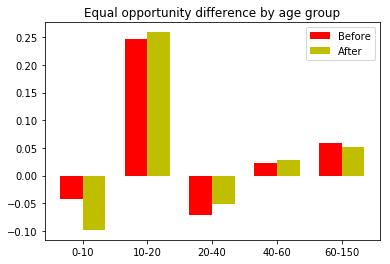

In [38]:
# Metrics sliced by age
age_range_intervals = [0, 10, 20, 40, 60, 150]
nodebiasing_perf = []
debiasing_perf = []

for idx in range(len(age_range_intervals)-1):
    start = age_range_intervals[idx]
    end = age_range_intervals[idx+1]
    ids = np.where((age_test>start) & (age_test<end))
    true_dataset = dataset_wrapper(outcome=y_test[ids], protected=p_test[ids],
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups,
                                   favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label)
    transf_pred_dataset = dataset_wrapper(outcome=y_pred_transf[ids], protected=p_test[ids],
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups=privileged_groups,
                                          favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)
    pred_dataset = dataset_wrapper(outcome=y_pred[ids], protected=p_test[ids],
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups,
                                   favorable_label=favorable_label,
                                   unfavorable_label=unfavorable_label)
 
    classified_metric_nodebiasing_test = ClassificationMetric(true_dataset, 
                                                 pred_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    classified_metric_debiasing_test = ClassificationMetric(true_dataset, 
                                                 transf_pred_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    nodebiasing_perf.append(classified_metric_nodebiasing_test.equal_opportunity_difference())
    debiasing_perf.append(classified_metric_debiasing_test.equal_opportunity_difference())

N = len(age_range_intervals)-1
fig, ax = plt.subplots()
ind = np.arange(N)
width = 0.35
p1 = ax.bar(ind, nodebiasing_perf, width, color='r')
p2 = ax.bar(ind + width, debiasing_perf, width,
            color='y')
ax.set_title('Equal opportunity difference by age group')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([str(age_range_intervals[idx])+'-'+str(age_range_intervals[idx+1]) for idx in range(N)])

ax.legend((p1[0], p2[0]), ('Before', 'After'))
ax.autoscale_view()

plt.show()

# Conclusions
In this tutorial, we have examined fairness in the scenario of binary classification with face images. We discussed methods to process several attributes of images, outcome variables, and protected attributes and created aif360 ready dataset objects on which many bias mitigation algorithms can be easily applied and fairness metrics can be easliy computed. We used the reweighing algorithm with the aim of improving the algorithmic fairness of the learned classifiers. The empirical results show slight improvement in the case of debiased model over the vanilla model. When sliced by age group, the results appear to be mixed bag and thus has scope for further improvements by considering age groups while learning models. 